# Convolutional Neural Networks for digit image classification

The popular [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit image classification dataset contains $60'000+10'000$ handwritten digits to be classified as a number between $0$ and $9$.

The sequence of (more and more complex) models defined below will eventually arrive at the one suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Steps

1. Loading and plotting the mnist dataset
2. Setting the sceene for image classification
3. Defining and evaluating the baseline model
4. Adding Pooling
5. Adding a CNN Kernel
6. Adding another dense output layer

## Loading and plotting the MNIST dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


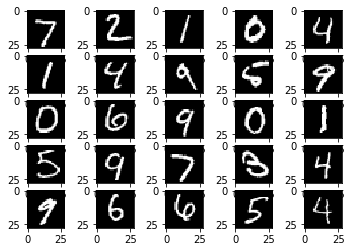

In [1]:
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, i+1)
	# plot raw pixel data
	pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

## Setting the sceene for image classification

Fix necessary imports.

In [2]:
from numpy import zeros
from numpy import unique
from numpy import argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy

Reshape data to have a single b/w channel.

In [3]:
orig_shape = x_train.shape[1:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
in_shape = x_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (28, 28)
After: (28, 28, 1)


Determine the number of classes.

In [4]:
n_classes = len(unique(y_train))
print("Classes: {0}".format(n_classes))

Classes: 10


Normalize pixel values `int[0..255]` $\rightarrow$ `float32[0..1]`.

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Function to define the CNN model architecture and compile it with constant surrogate goal function (loss), evaluation metrics, and optimizer. We will vary `depth`, `kernel_width`, and `pool_stride` of the models.

In [16]:
def make_model(depth, kernel_width, pool_stride):
    model = Sequential()
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu', input_shape=in_shape))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Define learning parameters for all models.

In [17]:
EPOCHS = 10
BATCH_SIZE = 128

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Function to show the history of training.

In [36]:
def plot_metrics(history):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
    metrics =  ['loss', 'accuracy']
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(1,2,n+1)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],
             color=colors[0], linestyle="--", label='Val')
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1])
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

## Baseline

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=1x1`, i.e., no effective CNN.

In [19]:
baseline = make_model(1,1,1)
baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 1)         2         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,852
Trainable params: 7,852
Non-trainable params: 0
_________________________________________________________________


Note that the kernel has one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the CNN and the pooling layers are equal to their inputs.

We train the baseline model.

In [20]:
baseline_history = baseline.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 55us/sample - loss: 0.6123 - accuracy: 0.8408 - val_loss: 0.3377 - val_accuracy: 0.9065
Epoch 2/10
60000/60000 [==============================] - 3s 51us/sample - loss: 0.3231 - accuracy: 0.9099 - val_loss: 0.2931 - val_accuracy: 0.9160
Epoch 3/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.2939 - accuracy: 0.9164 - val_loss: 0.2773 - val_accuracy: 0.9195
Epoch 4/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.2796 - accuracy: 0.9212 - val_loss: 0.2733 - val_accuracy: 0.9212
Epoch 5/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.2716 - accuracy: 0.9233 - val_loss: 0.2737 - val_accuracy: 0.9242
Epoch 6/10
60000/60000 [==============================] - 3s 54us/sample - loss: 0.2663 - accuracy: 0.9261 - val_loss: 0.2665 - val_accuracy: 0.9238
Epoch 7/10
60000/60000 [==============================] 

... and show the history of training.

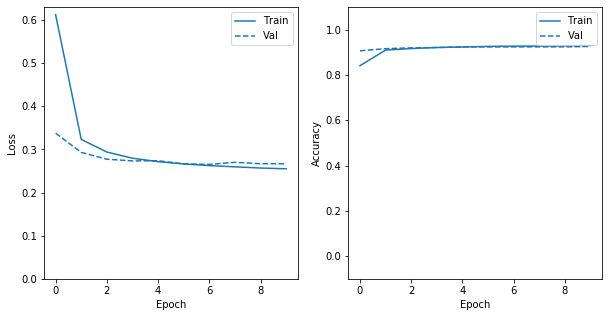

In [21]:
plot_metrics(baseline_history) 

We evaluate the trained model.

In [22]:
loss, acc = baseline.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.926


Use the model to  make a prediction.

In [26]:
def print_res(model):
    i_range = 10
    ys = zeros(i_range * i_range)
    class bcolors:
        FAIL = '\033[91m'
        ENDC = '\033[0m'
    for i in range(10):
        for j in range(i_range):
            idx = i*i_range+j;
            image = x_test[idx]
            yhat = model.predict([[image]])
            ys[idx] = argmax(yhat)
            print('%d ' % ys[idx], end = '')
        print()
    print("--")
    for i in range(i_range):
        for j in range(i_range):
            idx = i*i_range+j;
            y = y_test[idx]
            if y==ys[idx]:
                print('%d ' % y, end = '')
            else:
                print(f"{bcolors.FAIL}%d {bcolors.ENDC}" % y, end = '')            
        print()

In [27]:
print_res(baseline)

7 2 1 0 4 1 4 9 6 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 6 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 2 7 4 2 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


There are 4% mistatakes in the first 100 images. The classic dense layer does quite good already.

## Adding Pooling

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=2x2`, i.e., no effective CNN and we even squeeze the image size.

In [38]:
model1 = make_model(1,1,2)
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 1)         2         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1970      
Total params: 1,972
Trainable params: 1,972
Non-trainable params: 0
_________________________________________________________________


The kernel has still one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the pooling layers is one quater (half in each dimension) of the CNN in- and output.

We train the first CNN model.

In [39]:
model1_history = model1.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 42us/sample - loss: 0.9284 - accuracy: 0.7628 - val_loss: 0.4702 - val_accuracy: 0.8794
Epoch 2/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.4176 - accuracy: 0.8837 - val_loss: 0.3562 - val_accuracy: 0.8993
Epoch 3/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.3539 - accuracy: 0.8961 - val_loss: 0.3246 - val_accuracy: 0.9060
Epoch 4/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.3292 - accuracy: 0.9018 - val_loss: 0.3071 - val_accuracy: 0.9105
Epoch 5/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.3155 - accuracy: 0.9065 - val_loss: 0.2993 - val_accuracy: 0.9126
Epoch 6/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.3068 - accuracy: 0.9093 - val_loss: 0.2967 - val_accuracy: 0.9147
Epoch 7/10
60000/60000 [==============================] 

... and show the history of training.

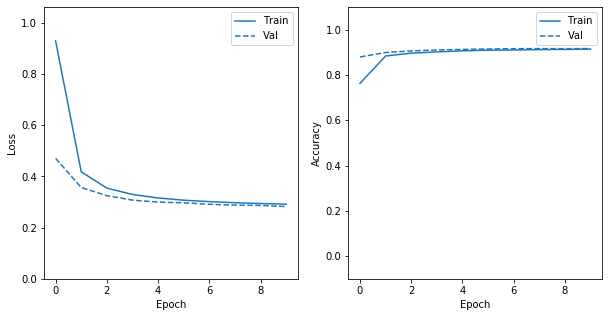

In [40]:
plot_metrics(model1_history) 

We evaluate the trained model.

In [44]:
loss, acc = model1.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.916


Use the model to  make a prediction.

In [45]:
print_res(model1)

7 2 1 0 4 1 4 9 6 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 5 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 4 2 7 4 7 4 3 0 
7 0 2 7 1 7 3 7 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


No surprise that the accuracy drops and that there are more mistatakes (7%) in the first 100 images.

## Adding a CNN Kernel

We set `depth=1`, `kernel_width=3x3`, and `pool_stride=2x2`, i.e., one effective CNN layer followed by the pooling layer.

In [47]:
model2 = make_model(1,3,2)
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 1)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 169)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1700      
Total params: 1,710
Trainable params: 1,710
Non-trainable params: 0
_________________________________________________________________


The kernel has still $3\times 3$ weights and one bias, i.e., `Param = 10` for the CNN layer. No padding is applied, so the CNN layer 'eats' one pixel at the corners, i.e., its output shape is `(26, 26, 1)`. The output of the pooling layers is one quater (half in $x$ and $y$ dimension) of the CNN output.

We train the first real CNN model.

In [48]:
model2_history = model2.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.8227 - accuracy: 0.7572 - val_loss: 0.3814 - val_accuracy: 0.8919
Epoch 2/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3596 - accuracy: 0.8948 - val_loss: 0.3129 - val_accuracy: 0.9104
Epoch 3/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.3188 - accuracy: 0.9073 - val_loss: 0.2981 - val_accuracy: 0.9144
Epoch 4/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.3041 - accuracy: 0.9105 - val_loss: 0.2856 - val_accuracy: 0.9175
Epoch 5/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2953 - accuracy: 0.9143 - val_loss: 0.2781 - val_accuracy: 0.9203
Epoch 6/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.2893 - accuracy: 0.9161 - val_loss: 0.2743 - val_accuracy: 0.9210
Epoch 7/10
60000/60000 [==============================] 

... and show the history of training.

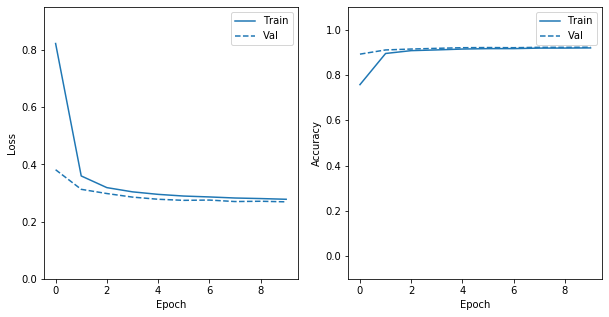

In [49]:
plot_metrics(model2_history) 

We evaluate the trained model.

In [51]:
loss, acc = model2.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.923


Use the model to  make a prediction.

In [52]:
print_res(model2)

7 2 1 0 4 1 4 9 6 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 6 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 2 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 4 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


The accuracy and that the number of mistatakes in the first 100 images is on par with the baseline model.

## Adding Parallel CNN Kernels

We set `depth=32`, and keep `kernel_width=3x3`, and `pool_stride=2x2`.

In [53]:
model3 = make_model(32,3,2)
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


There are $32$ kernels has each with $3 \times 3$ weights and one bias, i.e., `Param = 32` for the CNN layer. As no padding is applied, the CNN layer's output shape is the same for the $x$ and $y$ dimensions , but it add depth: `(26, 26, 32)`. The output of the pooling layers is one quater (half in $x$ and $y$ dimension) of the CNN output, but it keeps the depth.

We train the first CNN model.

In [54]:
model3_history = model3.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 115us/sample - loss: 0.3390 - accuracy: 0.9099 - val_loss: 0.1409 - val_accuracy: 0.9617
Epoch 2/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.1172 - accuracy: 0.9670 - val_loss: 0.0905 - val_accuracy: 0.9724
Epoch 3/10
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0825 - accuracy: 0.9769 - val_loss: 0.0733 - val_accuracy: 0.9774
Epoch 4/10
60000/60000 [==============================] - 8s 125us/sample - loss: 0.0673 - accuracy: 0.9808 - val_loss: 0.0655 - val_accuracy: 0.9785
Epoch 5/10
60000/60000 [==============================] - 8s 125us/sample - loss: 0.0582 - accuracy: 0.9832 - val_loss: 0.0578 - val_accuracy: 0.9810
Epoch 6/10
60000/60000 [==============================] - 8s 131us/sample - loss: 0.0515 - accuracy: 0.9850 - val_loss: 0.0569 - val_accuracy: 0.9821
Epoch 7/10
60000/60000 [==========================

... and show the history of training.

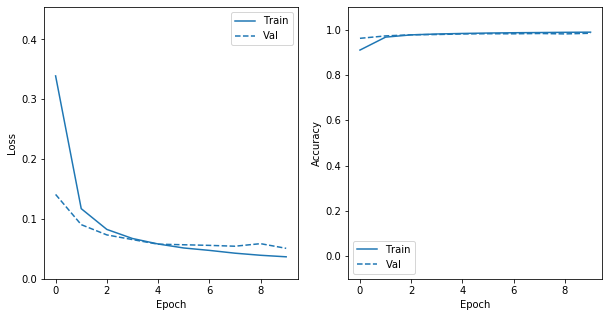

In [69]:
plot_metrics(model3_history) 

We evaluate the trained model.

In [57]:
loss, acc = model3.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.984


Use the model to  make a prediction.

In [59]:
print_res(model3)

7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 8 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 4 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


The accuracy goes up to almost 100% and there are only 2% mistatakes in the first 100 images.

## Adding another dense output layer

We keep `depth=32`, and keep `kernel_width=3x3`, and `pool_stride=2x2` but add another dense layer before the output layer as suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

In [64]:
model4 = Sequential()
model4.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model4.add(MaxPool2D((2, 2)))
model4.add(Flatten())
model4.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dropout(0.5))
model4.add(Dense(n_classes, activation='softmax'))

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               540900    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_______________________________________________

This lets the number of parameters grow to over half a million!

We train this final CNN model.

In [65]:
model4_history = model4.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 202us/sample - loss: 0.3220 - accuracy: 0.9030 - val_loss: 0.0892 - val_accuracy: 0.9712
Epoch 2/10
60000/60000 [==============================] - 13s 213us/sample - loss: 0.1323 - accuracy: 0.9606 - val_loss: 0.0588 - val_accuracy: 0.9803
Epoch 3/10
60000/60000 [==============================] - 13s 224us/sample - loss: 0.0968 - accuracy: 0.9708 - val_loss: 0.0500 - val_accuracy: 0.9829
Epoch 4/10
60000/60000 [==============================] - 15s 242us/sample - loss: 0.0799 - accuracy: 0.9762 - val_loss: 0.0462 - val_accuracy: 0.9842
Epoch 5/10
60000/60000 [==============================] - 14s 230us/sample - loss: 0.0686 - accuracy: 0.9793 - val_loss: 0.0446 - val_accuracy: 0.9859
Epoch 6/10
60000/60000 [==============================] - 14s 228us/sample - loss: 0.0599 - accuracy: 0.9810 - val_loss: 0.0458 - val_accuracy: 0.9854
Epoch 7/10
60000/60000 [====================

Training time goes up to $12\ldots 15 \mathit{s}$ compared to $<10 \mathit{s}$ per epoch before. 

Here the history of training.

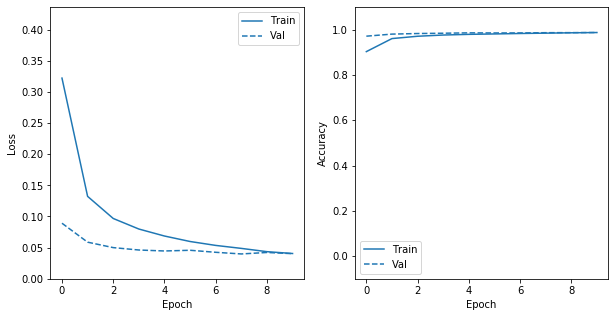

In [66]:
plot_metrics(model4_history) 

We evaluate the trained model.

In [67]:
loss, acc = model4.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.987


Use the model to  make a prediction.

In [68]:
print_res(model4)

7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 5 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


The accuracy goes up a bit and there are only 1% mistatakes left in the first 100 images.